# Heuristic model

We will fit our heuristic model by using experimental data from the paper of [Lei et al.](https://doi.org/10.1016/j.jallcom.2014.09.169) for LFP system.

First, we import the libraries that we will be using throughout this example:

In [1]:
import galpynostatic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Data visualization

We define a [numpy](https://numpy.org/) array with the C-rates that were used to perform the measurements in the experiment.

In [2]:
C_rates = np.array([0.2, 0.5, 1, 2, 5, 10])

For each one of these C-rates we have a galvanostatic profile as a csv file, we read them with [pandas](https://pandas.pydata.org/) and store them in a list for further preprocessing.

In [3]:
gprofiles = [pd.read_csv(f"../_static/{c_rate}C.csv") for c_rate in C_rates]
gprofiles[0].keys()

Index(['capacity', 'voltage'], dtype='object')

we have a pd.DataFrame for each curve with a capacity and a voltage column. We also define from their work the equilibrium potential and our choice for the cut-off potential (which is the one of the distributed map-datasets).

In [4]:
eq_pot, vcut = 3.45, 0.15

We plot the curves to visualize them in the region of interest:

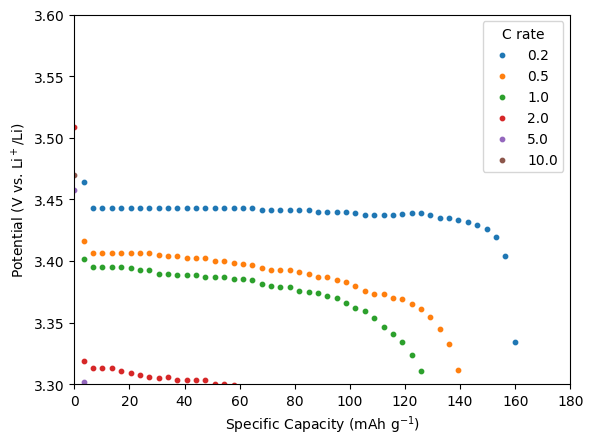

In [5]:
fig, ax = plt.subplots()

for c_rate, df in zip(C_rates, gprofiles):
    ax.scatter(df.capacity, df.voltage, s=10, label=f"{c_rate}")
    
ax.set_xlim((0, 180))
ax.set_ylim((eq_pot - vcut, eq_pot + vcut))
ax.set_xlabel(r"Specific Capacity (mAh g$^{-1}$)")
ax.set_ylabel(r"Potential (V vs. Li$^+$/Li)")
ax.legend(title="C rate")
plt.show()

## Data preprocessing

In the physics-based heuristic model we present here, we are not interested in the complete behavior of the profile, but focus our analysis on the points where each curve intersects at a cut-off potential below the equilibrium potential. To obtain these values we can use the `galpynostatic.preprocessing` module.

In [6]:
gdc = galpynostatic.preprocessing.GetDischargeCapacities(eq_pot=eq_pot, vcut=vcut)
dc = gdc.fit_transform(gprofiles)
dc

array([160.27912017, 141.21537819, 128.30040942,  55.62272794,
         3.53156547,   1.62308932])

We must normalize these currents by a maximum value that we define (here we use the maximum value of the capacity for the lowest C-rate reported in the paper as 168.9 mAh g$^{-1}$) to obtain the maximum SOC value between 0 and 1, which are going to be the target values for the fitting of our model.

In [7]:
soc = dc / 168.9

## Model fitting

First, we show the data in the form to be used by the model

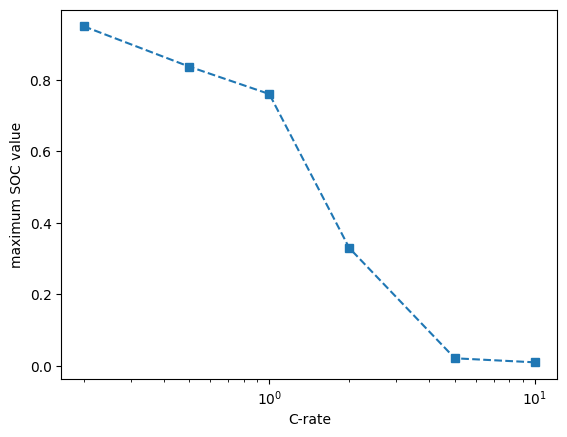

In [8]:
fig, ax = plt.subplots()

plt.plot(C_rates, soc, marker="s", ls="--")

plt.xlabel("C-rate")
plt.ylabel("maximum SOC value")
plt.xscale("log")
plt.show()

and reshape the C-rate values as in the usual way used by [scikit-learn](https://scikit-learn.org/stable/) convention.

In [9]:
C_rates = C_rates.reshape(-1, 1)

In the paper it is mentioned that the particle sizes are distributed between 200-500 nm, we take the mid point and give it in cm which is the required unit for this parameter.

In [10]:
d = 3.5e-5

We load the surface data for spherical geometry with a 150 mV cut-off potential and define the z-value which is a number that depends on the geometry, here it is 3.

In [11]:
spherical = galpynostatic.datasets.load_spherical()
z = 3

We now have all the information we need to fit the model.

In [12]:
greg = galpynostatic.model.GalvanostaticRegressor(dataset=spherical, d=d, z=z)
greg.fit(C_rates, soc)

GalvanostaticRegressor(d=3.5e-05,
                       dataset=         l   xi     xmax
0    -4.00  2.0  0.99706
1    -4.00  1.9  0.99706
2    -4.00  1.8  0.99705
3    -4.00  1.7  0.99705
4    -4.00  1.6  0.99705
...    ...  ...      ...
1339  1.75 -3.1  0.00000
1340  1.75 -3.2  0.00000
1341  1.75 -3.3  0.00000
1342  1.75 -3.4  0.00000
1343  1.75 -3.5  0.00000

[1344 rows x 3 columns])

Two types of plots are available, one to visualize the region of the map where the experimental data are located after the fitting

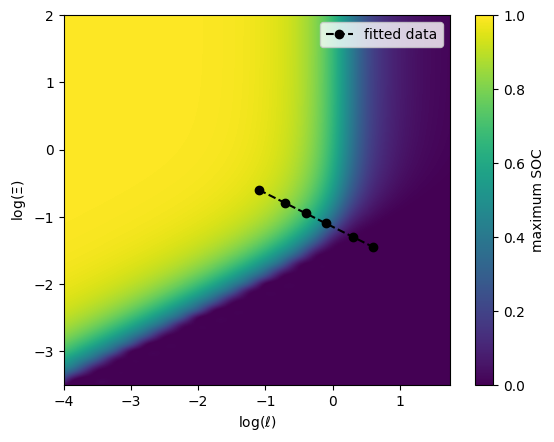

In [13]:
greg.plot.in_render_map(C_rates)
plt.legend()
plt.show()

and another to visualize the predicted versus experimental values in the same format as used for the fitting.

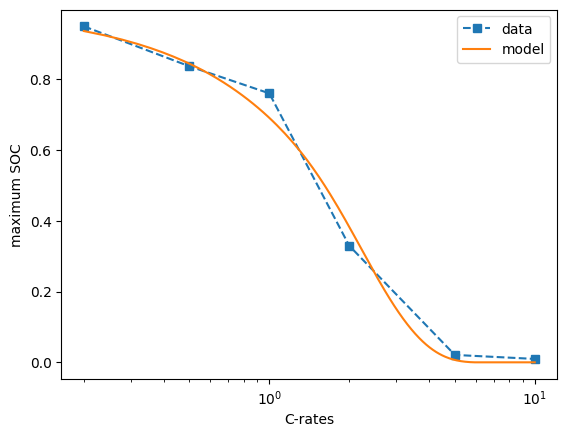

In [14]:
greg.plot.versus_data(C_rates, soc)
plt.legend()
plt.show()

## Predictions

We can obtain fundamental parameters of the system by accessing attributes of the `GalvanostaticRegressor` model, such as the diffusion coefficient (with its uncertainty)

In [15]:
print(f"{greg.dcoeff_:.2e} +/- {greg.dcoeff_err_:.0e} cm^2/s")

2.85e-13 +/- 1e-14 cm^2/s


which in this case is in high agreement with the three values reported in their work of 1.04e-12, 1.74e-13 and 8.22e-13 (EIS measurements). In addition, we can obtain the kinetic rate constant

In [16]:
print(f"{greg.k0_:.2e} +/- {greg.k0_err_:.0e} cm/s")

1.00e-09 +/- 3e-11 cm/s


that is also in high agreement with the experimental one of 1.23e-9, calculated using the [Butler-Volmer equation](https://en.wikipedia.org/wiki/Butler%E2%80%93Volmer_equation) with the reported exchange current density value.

Finally, there is a fast-charging criteria, proposed by the _United States Advanced Battery Consortium_ (USABC), which aims for extremely fast-charging of 80% of the State-of-Charge (SOC) in 15 minutes. This translates to a maximum SOC value of 0.8 and a C-rate of 4C. A prediction on the particle size needed to satisfy this criterion can be quickly made with the `optimal_particle_size` function in `galpynostatic.make_prediction` module (which has the default values of the criterion defined).

In [17]:
d_new, d_new_err = galpynostatic.make_prediction.optimal_particle_size(greg)
print(f"{d_new:.3f} +/- {d_new_err:.3f} micrometers")

0.084 +/- 0.002 micrometers


This value can be compared with the original one (d)

In [18]:
1e4 * d

0.35

where it can be seen that our model predicts that the system should be improved by reducing the particle size by about one order of magnitude.